<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/13_rnn/07_ConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional LSTMを用いた動画像予測

---

## Google ColabでGoogleドライブをマウントする
* 以下のコードを実行するとURLが出てくるので，クリック
* Googleアカウントに許可を求めたらcodeが出るのでコピー
* コピーしたcodeを[空白]にペースト

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#ConvLSTM
ConvLSTMはLSTMの内部構造に畳み込み層を導入した再帰型のネットワークです．LSTMの内部に畳み込み層を導入することで，動画像を順伝播逆伝播できるネットワークとなっています．このネットワークは，時系列データを入力として受け取り，中間層のユニットの出力が自分自身に戻る「帰還路」を持つため，過去の情報を保持しやすい構造となっています．今回はMoving Mnistを使って動画予測を行います．


<img src="https://github.com/himidev/Lecture/blob/main/13_rnn/07_ConvLSTM/convLSTM.png?raw=true" width = 70%>


# モジュールのインポート

In [ ]:
import gzip
import math
import os
import random
import sys
import logging
import numpy as np
from PIL import Image
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt


import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import nn
from collections import OrderedDict

# MovingMNIST

In [ ]:
!wget -q "https://drive.google.com/uc?export=download&id=1lhue3SAroqRtLgPbQknRhfMClCR45qik" -O train-images-idx3-ubyte.gz

# Data loader
Moving Mnistの読み込みを行います．このときバッチ毎にシーケンス数が同じになるように“class MovingMNIST"内で処理を行います．MovingMNISTのリンク先[https://drive.google.com/file/d/1lhue3SAroqRtLgPbQknRhfMClCR45qik/view?usp=sharing]． 

In [ ]:
def load_mnist(root):
    path = os.path.join(root)
    with gzip.open(path, 'rb') as f:
        mnist = np.frombuffer(f.read(), np.uint8, offset=16)
        mnist = mnist.reshape(-1, 28, 28)
    return mnist


def load_fixed_set(root, is_train):
    filename = 'mnist_test_seq.npy'
    path = os.path.join(root, filename)
    dataset = np.load(path)
    dataset = dataset[..., np.newaxis]
    return dataset


class MovingMNIST(data.Dataset):
    def __init__(self, root, is_train, n_frames_input, n_frames_output, num_objects,
                 transform=None):
        super(MovingMNIST, self).__init__()

        self.dataset = None
        if is_train:
            self.mnist = load_mnist(root)
        else:
            if num_objects[0] != 2:
                self.mnist = load_mnist(root)
            else:
                self.dataset = load_fixed_set(root, False)
        self.length = int(1e4) if self.dataset is None else self.dataset.shape[1]

        self.is_train = is_train
        self.num_objects = num_objects
        self.n_frames_input = n_frames_input
        self.n_frames_output = n_frames_output
        self.n_frames_total = self.n_frames_input + self.n_frames_output
        self.transform = transform
        self.image_size_ = 64
        self.digit_size_ = 28
        self.step_length_ = 0.1

    def get_random_trajectory(self, seq_length):
        canvas_size = self.image_size_ - self.digit_size_
        x = random.random()
        y = random.random()
        theta = random.random() * 2 * np.pi
        v_y = np.sin(theta)
        v_x = np.cos(theta)

        start_y = np.zeros(seq_length)
        start_x = np.zeros(seq_length)
        for i in range(seq_length):
            y += v_y * self.step_length_
            x += v_x * self.step_length_

            if x <= 0:
                x = 0
                v_x = -v_x
            if x >= 1.0:
                x = 1.0
                v_x = -v_x
            if y <= 0:
                y = 0
                v_y = -v_y
            if y >= 1.0:
                y = 1.0
                v_y = -v_y
            start_y[i] = y
            start_x[i] = x

        start_y = (canvas_size * start_y).astype(np.int32)
        start_x = (canvas_size * start_x).astype(np.int32)
        return start_y, start_x

    def generate_moving_mnist(self, num_digits=2):
        data = np.zeros((self.n_frames_total, self.image_size_, self.image_size_), dtype=np.float32)
        for n in range(num_digits):
            start_y, start_x = self.get_random_trajectory(self.n_frames_total)
            ind = random.randint(0, self.mnist.shape[0] - 1)
            digit_image = self.mnist[ind]
            for i in range(self.n_frames_total):
                top = start_y[i]
                left = start_x[i]
                bottom = top + self.digit_size_
                right = left + self.digit_size_
                data[i, top:bottom, left:right] = np.maximum(data[i, top:bottom, left:right], digit_image)

        data = data[..., np.newaxis]
        return data

    def __getitem__(self, idx):
        length = self.n_frames_input + self.n_frames_output
        if self.is_train or self.num_objects[0] != 2:
            num_digits = random.choice(self.num_objects)
            images = self.generate_moving_mnist(num_digits)
        else:
            images = self.dataset[:, idx, ...]


        r = 1
        w = int(64 / r)
        images = images.reshape((length, w, r, w, r)).transpose(0, 2, 4, 1, 3).reshape((length, r * r, w, w))

        input = images[:self.n_frames_input]
        if self.n_frames_output > 0:
            output = images[self.n_frames_input:length]
        else:
            output = []

        frozen = input[-1]

        output = torch.from_numpy(output / 255.0).contiguous().float()
        input = torch.from_numpy(input / 255.0).contiguous().float()

        out = [idx, output, input, frozen, np.zeros(1)]
        return out

    def __len__(self):
        return self.length

# 学習パラメータの設定やデータの読み込み
 各パラメータを設定します．本実験では20フレームを用い，観測10フレームの動画像を入力し，その後の10フレームの予測動画像を出力します．MovingMNIST内のrootで，driveに置いてあるファイルパスを指定します．このとき，学習用と評価用にsplitしたファイルが各Folderです．


In [ ]:
frame_input = 10
frame_output = 10
batch = 8
lr = 0.001
epochs = 10

trainFolder = MovingMNIST(is_train=True,
                          #root='/content/drive/My Drive/Colab_Notebooks/train-images-idx3-ubyte.gz',
                          root='./train-images-idx3-ubyte.gz',
                          n_frames_input=frame_input,
                          n_frames_output=frame_output,
                          num_objects=[3])
validFolder = MovingMNIST(is_train=False,
                          #root='/content/drive/My Drive/Colab_Notebooks/train-images-idx3-ubyte.gz',
                          root='./train-images-idx3-ubyte.gz',
                          n_frames_input=frame_input,
                          n_frames_output=frame_output,
                          num_objects=[3])

trainLoader = torch.utils.data.DataLoader(trainFolder,
                                          batch_size=batch,
                                          shuffle=False)
validLoader = torch.utils.data.DataLoader(validFolder,
                                          batch_size=batch,
                                          shuffle=False)

# Layer作成
Encoder，Decoderで指定されたlayer name毎に処理を行います．

In [ ]:
def make_layers(block):
    layers = []
    for layer_name, v in block.items():
        if 'pool' in layer_name:
            layer = nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2])
            layers.append((layer_name, layer))
        elif 'deconv' in layer_name:
            transposeConv2d = nn.ConvTranspose2d(in_channels=v[0],
                                                 out_channels=v[1],
                                                 kernel_size=v[2],
                                                 stride=v[3],
                                                 padding=v[4])
            layers.append((layer_name, transposeConv2d))
            if 'relu' in layer_name:
                layers.append(('relu_' + layer_name, nn.ReLU(inplace=True)))
            elif 'leaky' in layer_name:
                layers.append(('leaky_' + layer_name,
                               nn.LeakyReLU(negative_slope=0.2, inplace=True)))
        elif 'conv' in layer_name:
            conv2d = nn.Conv2d(in_channels=v[0],
                               out_channels=v[1],
                               kernel_size=v[2],
                               stride=v[3],
                               padding=v[4])
            layers.append((layer_name, conv2d))
            if 'relu' in layer_name:
                layers.append(('relu_' + layer_name, nn.ReLU(inplace=True)))
            elif 'leaky' in layer_name:
                layers.append(('leaky_' + layer_name,
                               nn.LeakyReLU(negative_slope=0.2, inplace=True)))
        else:
            raise NotImplementedError
    return nn.Sequential(OrderedDict(layers))

#Encoder
Moving Mnistの画像特徴量をConvolutionして捉えます．このとき，各時刻で得られる画像特徴量をConvolutional LSTMで時間方向に伝播することで，動画像における特徴量を求めます．

In [ ]:
class Encoder(nn.Module):
    def __init__(self, subnets, rnns):
        super().__init__()
        assert len(subnets) == len(rnns)
        self.blocks = len(subnets)

        for index, (params, rnn) in enumerate(zip(subnets, rnns), 1):
            setattr(self, 'stage' + str(index), make_layers(params))
            setattr(self, 'rnn' + str(index), rnn)

    def forward_by_stage(self, inputs, subnet, rnn):
        seq_number, batch_size, input_channel, height, width = inputs.size()
        inputs = torch.reshape(inputs, (-1, input_channel, height, width))
        # convolution
        # to BxS, C, H, W
        inputs = subnet(inputs)
        inputs = torch.reshape(inputs, (seq_number, batch_size, inputs.size(1),
                                        inputs.size(2), inputs.size(3)))
        # recurrent
        outputs_stage, state_stage = rnn(inputs, None)
        # to B, S, C, H, W
        return outputs_stage, state_stage

    def forward(self, inputs):
        inputs = inputs.transpose(0, 1)  # to S,B,1,H,W
        hidden_states = []
        logging.debug(inputs.size())
        # 層数で繰り返す
        for i in range(1, self.blocks + 1):
            inputs, state_stage = self.forward_by_stage(
                inputs, getattr(self, 'stage' + str(i)),
                getattr(self, 'rnn' + str(i)))
            hidden_states.append(state_stage)
        return tuple(hidden_states)

#Decoder
畳み込んだ特徴量をDeconvolutionします．このとき，各時刻で得られる画像特徴量をDeconvolutional LSTMで時間方向に伝播しつつ，元の動画像サイズまで復元します．

In [ ]:
class Decoder(nn.Module):
    def __init__(self, subnets, rnns):
        super().__init__()
        assert len(subnets) == len(rnns)

        self.blocks = len(subnets)

        for index, (params, rnn) in enumerate(zip(subnets, rnns)):
            setattr(self, 'rnn' + str(self.blocks - index), rnn)
            setattr(self, 'stage' + str(self.blocks - index),
                    make_layers(params))

    def forward_by_stage(self, inputs, state, subnet, rnn):
        # recurrent
        # to B, C, H, W
        inputs, state_stage = rnn(inputs, state, seq_len=10)
        # to S, B, C, H, W
        seq_number, batch_size, input_channel, height, width = inputs.size()
        inputs = torch.reshape(inputs, (-1, input_channel, height, width))
        # deconvolution
        inputs = subnet(inputs)
        # to B*S, C, H, W
        inputs = torch.reshape(inputs, (seq_number, batch_size, inputs.size(1),
                                        inputs.size(2), inputs.size(3)))
        return inputs

    def forward(self, hidden_states):
        # Decoderの入力はEncoderの最後の内部状態のみ
        inputs = self.forward_by_stage(None, hidden_states[-1],
                                       getattr(self, 'stage3'),
                                       getattr(self, 'rnn3'))
        for i in list(range(1, self.blocks))[::-1]:
            inputs = self.forward_by_stage(inputs, hidden_states[i - 1],
                                           getattr(self, 'stage' + str(i)),
                                           getattr(self, 'rnn' + str(i)))
        inputs = inputs.transpose(0, 1)  # to B,S,1,H, W
        return inputs


# Encoder-Decoderに各入力を渡す

In [ ]:
class activation():

    def __init__(self, act_type, negative_slope=0.2, inplace=True):
        super().__init__()
        self._act_type = act_type
        self.negative_slope = negative_slope
        self.inplace = inplace

    def __call__(self, input):
        if self._act_type == 'leaky':
            return F.leaky_relu(input, negative_slope=self.negative_slope, inplace=self.inplace)
        elif self._act_type == 'relu':
            return F.relu(input, inplace=self.inplace)
        elif self._act_type == 'sigmoid':
            return torch.sigmoid(input)
        else:
            raise NotImplementedError


class ED(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input):
        state = self.encoder(input)
        output = self.decoder(state)
        return output

# Convolution LSTM
動画像における特徴量を求めます．Encoder-Decoderへの引数としてencoder_paramsとdecoder_paramsを定義します．Conv.LSTM層では，それぞれConvolutionまたはDeconvolution処理を行います．

In [ ]:
class CLSTM_cell(nn.Module):
    """ConvLSTMCell
    """
    def __init__(self, shape, input_channels, filter_size, num_features):
        super(CLSTM_cell, self).__init__()

        self.shape = shape  # H, W
        self.input_channels = input_channels
        self.filter_size = filter_size
        self.num_features = num_features
        self.padding = (filter_size - 1) // 2
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_channels + self.num_features,
                      4 * self.num_features, self.filter_size, 1,
                      self.padding),
            nn.GroupNorm(4 * self.num_features // 32, 4 * self.num_features))
        
    # LSTMの計算を畳み込み演算に変えるのみでできます．
    # ただ，pytorchにはconv.lstmは実装されてないため自身で構築する必要があります．
    def forward(self, inputs=None, hidden_state=None, seq_len=10):
        # LSTMでいう初期内部状態
        if hidden_state is None:
            hx = torch.zeros(inputs.size(1), self.num_features, self.shape[0],
                             self.shape[1]).cuda()
            cx = torch.zeros(inputs.size(1), self.num_features, self.shape[0],
                             self.shape[1]).cuda()
        else:
            hx, cx = hidden_state
        output_inner = []
        # sequentialに内部状態を更新
        # LSTMと同じ計算
        for index in range(seq_len):
            if inputs is None:
                x = torch.zeros(hx.size(0), self.input_channels, self.shape[0],
                                self.shape[1]).cuda()
            else:
                x = inputs[index, ...]

            combined = torch.cat((x, hx), 1)
            gates = self.conv(combined)
            ingate, forgetgate, cellgate, outgate = torch.split(
                gates, self.num_features, dim=1)
            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            cellgate = torch.tanh(cellgate)
            outgate = torch.sigmoid(outgate)

            cy = (forgetgate * cx) + (ingate * cellgate)
            hy = outgate * torch.tanh(cy)
            output_inner.append(hy)
            hx = hy
            cx = cy
        return torch.stack(output_inner), (hy, cy)


from collections import OrderedDict
encoder_params = [
    [
        OrderedDict({'conv1_leaky_1': [1, 16, 3, 1, 1]}),
        OrderedDict({'conv2_leaky_1': [64, 64, 3, 2, 1]}),
        OrderedDict({'conv3_leaky_1': [96, 96, 3, 2, 1]}),
    ],

    [
        CLSTM_cell(shape=(64,64), input_channels=16, filter_size=5, num_features=64),
        CLSTM_cell(shape=(32,32), input_channels=64, filter_size=5, num_features=96),
        CLSTM_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96)
    ]
]

decoder_params = [
    [
        OrderedDict({'deconv1_leaky_1': [96, 96, 4, 2, 1]}),
        OrderedDict({'deconv2_leaky_1': [96, 96, 4, 2, 1]}),
        OrderedDict({
            'conv3_leaky_1': [64, 16, 3, 1, 1],
            'conv4_leaky_1': [16, 1, 1, 1, 0]
        }),
    ],

    [
        CLSTM_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96),
        CLSTM_cell(shape=(32,32), input_channels=96, filter_size=5, num_features=96),
        CLSTM_cell(shape=(64,64), input_channels=96, filter_size=5, num_features=64),
    ]
]

# モデル定義
EncoderとDecoderに各パラメータを引数として入れます．損失関数にはMSELossを用います．最適化手法にはAdamを使用します．

In [ ]:
encoder = Encoder(encoder_params[0], encoder_params[1]).cuda()
decoder = Decoder(decoder_params[0], decoder_params[1]).cuda()
net = ED(encoder, decoder)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.to(device)
lossfunction = nn.MSELoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=lr)

#学習
学習と検証用データを回します．動画特徴量を捉えるため，エポック数を少々増やさないとうまく学習されないのと，学習に3日前後使うので，注意してください．

In [ ]:
train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []
for epoch in range(0, epochs + 1):
    ######################
    # 学習
    ######################
    t = tqdm(trainLoader, leave=False, total=len(trainLoader))
    train_loss = 0
    test_loss = 0

    for i, (idx, targetVar, inputVar, _, _) in enumerate(t):
        inputs = inputVar.to(device)  # B,S,C,H,W
        label = targetVar.to(device)  # B,S,C,H,W
        optimizer.zero_grad()
        net.train()
        pred = net(inputs)  # B,S,C,H,W
        loss = lossfunction(pred, label)
        loss_aver = loss.item() / batch
        train_loss += loss_aver
        loss.backward()
        torch.nn.utils.clip_grad_value_(net.parameters(), clip_value=10.0)
        optimizer.step()

        t.set_postfix({
            'trainloss': '{:.6f}'.format(loss_aver),
            'epoch': '{:02d}'.format(epoch)
        })
    # モデルを保存    
    # torch.save(net.state_dict(), 'pre-train.pth')
    
    ######################
    # 検証
    ######################
    with torch.no_grad():
        net.eval()
        t = tqdm(validLoader, leave=False, total=len(validLoader))
        for i, (idx, targetVar, inputVar, _, _) in enumerate(t):
            if i == 3000:
                break
            inputs = inputVar.to(device)
            label = targetVar.to(device)
            pred = net(inputs)
            loss = lossfunction(pred, label)
            loss_aver = loss.item() / batch
            test_loss += loss_aver
            valid_losses.append(loss_aver)
            t.set_postfix({
                'validloss': '{:.6f}'.format(loss_aver),
                'epoch': '{:02d}'.format(epoch)
            })
    print('%03d-epoch: train_loss %.5f : val_loss %.5f' %(epoch, train_loss/len(t), test_loss/len(t)))
    torch.cuda.empty_cache()


# Pre-trained model
学習時間が長いので，学習済みモデルをインポートします．学習から始める場合は，学習のモデルを保存のコメントアウトを外します．

In [ ]:
!wget -q "https://drive.google.com/uc?export=download&id=1geXhoW6ij1JodjcOOqHTgYVjdFGbSraI" -O pre-train.pth
net.load_state_dict(torch.load("./pre-train.pth"))

<All keys matched successfully>

# 評価
予測した動画像と真値の動画像を比較します．損失計算はMSEで計算します．

In [ ]:
net.eval()
t = tqdm(validLoader, leave=False, total=len(validLoader))
test_loss = 0
for i, (idx, targetVar, inputVar, _, _) in enumerate(t):
    if i == 3000:
        break
    inputs = inputVar.to(device)
    label = targetVar.to(device)
    pred = net(inputs)
    loss = lossfunction(pred, label)
    loss_aver = loss.item() / batch
    test_loss += loss_aver
print('loss:{:.6f}'.format(test_loss/len(t)))

Streaming output truncated to the last 5000 lines.




 20%|██        | 252/1250 [01:20<05:14,  3.18it/s]




 20%|██        | 253/1250 [01:21<05:14,  3.17it/s]




 20%|██        | 254/1250 [01:21<05:13,  3.17it/s]




 20%|██        | 255/1250 [01:21<05:13,  3.17it/s]




 20%|██        | 256/1250 [01:22<05:13,  3.17it/s]




 21%|██        | 257/1250 [01:22<05:12,  3.17it/s]




 21%|██        | 258/1250 [01:22<05:13,  3.17it/s]




 21%|██        | 259/1250 [01:23<05:12,  3.17it/s]




 21%|██        | 260/1250 [01:23<05:12,  3.17it/s]




 21%|██        | 261/1250 [01:23<05:12,  3.17it/s]




 21%|██        | 262/1250 [01:23<05:11,  3.17it/s]




 21%|██        | 263/1250 [01:24<05:11,  3.17it/s]




 21%|██        | 264/1250 [01:24<05:11,  3.17it/s]




 21%|██        | 265/1250 [01:24<05:10,  3.17it/s]




 21%|██▏       | 266/1250 [01:25<05:10,  3.17it/s]




 21%|██▏       | 267/1250 [01:25<05:09,  3.17it/s]




 21%|██▏       | 268/1250 [01:25<05:09,  3.17it/s]




 22%|██▏  

loss:0.002377


# 可視化

  0%|          | 0/1250 [00:00<?, ?it/s]

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


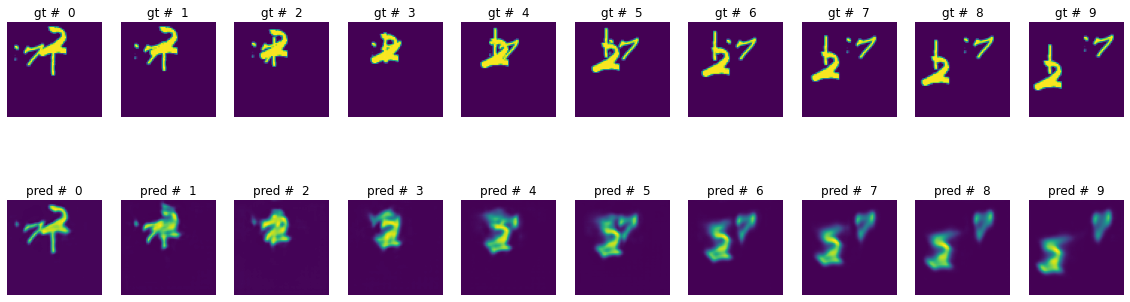

In [ ]:
net.eval()
t = tqdm(validLoader, leave=False, total=len(validLoader))
for i, (idx, targetVar, inputVar, _, _) in enumerate(t):
    if i == 3000:
        break
    inputs = inputVar.to(device)
    label = targetVar.to(device)
    pred = net(inputs)
    plt.figure(figsize=[20, 6])
    for i in range(10):
        plt.subplot(2, 10, i+1)
        plt.imshow(label[0, i, 0].detach().cpu().numpy())
        plt.axis('off')
        plt.title('gt # %2d' %i)
        plt.subplot(2, 10, i+11)
        plt.imshow(pred[0, i, 0].detach().cpu().numpy())
        plt.axis('off')
        plt.title('pred # %2d' %i)
    sys.exit()

可視化すると以下のようになります．


<img src="https://github.com/himidev/Lecture/blob/main/13_rnn/07_ConvLSTM/pred1.png?raw=true" width = 100%>

<img src="https://github.com/himidev/Lecture/blob/main/13_rnn/07_ConvLSTM/pred2.png?raw=true" width = 100%>


# 課題
各自のサーバでコードを動かしてみましょう．